In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator,
                          cross_val_multiscore, LinearModel, get_coef)

In [2]:
epochs=mne.read_epochs('C:\\Users\\new user\\EEG data\\data\\Ex10_Suj1_Run1-epo.fif',preload=True)

Reading C:\Users\new user\EEG data\data\Ex10_Suj1_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
280 matching events found
Created an SSP operator (subspace dimension = 1)
280 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


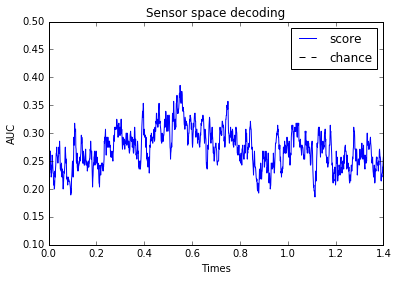

In [10]:
epochs.pick_types(eeg=True, exclude='bads')
X = epochs.get_data()  # EEG signals: n_epochs, n_channels, n_times
y = epochs.events[:, 2]  #

clf = make_pipeline(StandardScaler(), LogisticRegression())

time_decod = SlidingEstimator(clf, n_jobs=1)

scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()

In [19]:
print(get_coef(time_decod, inverse_transform=True).shape)

(61L, 4L, 1401L)


In [18]:
# You can retrieve the spatial filters and spatial patterns if you explicitly
# use a LinearModel
clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression()))
time_decod = SlidingEstimator(clf, n_jobs=1)
time_decod.fit(X, y)

coef = get_coef(time_decod)
evoked = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
evoked.plot_joint(times=np.arange(0., .500, .100), title='patterns')

ValueError: Data must be a 2D array of shape (n_channels, n_samples)

TypeError: Invalid dimensions for image data

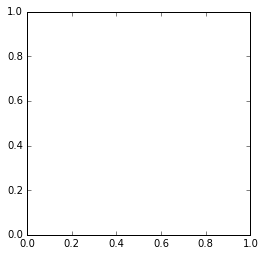

In [21]:
# Plot the full matrix
fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=epochs.times[[0, -1, 0, -1]], vmin=0., vmax=1.)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal Generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
plt.colorbar(im, ax=ax)
plt.show()